In [1]:
import collections
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt


tax_rates = [
    (9700, 0.10),
    (39475, 0.12),
    (84200, 0.22),
    (160725, 0.24),
    (204100, 0.32),
    (510300, 0.35),
    (1000**5, 0.37)
]

ca_tax_rates = [
    (8544, 0.01),
    (20255, 0.02),
    (31969, 0.04),
    (44377, 0.06),
    (56085, 0.08),
    (286492, 0.093),
    (343788, 0.103),
    (572980, 0.113),
    (1000**5, 0.123)
]

ma_tax_rates = [
    (1000 ** 5, 0.0505 ) # Flat income tax in MA
]

example_tax_rates = [ # Example 4% on some income, just because, representing some arbitrary state that's not CA
    (10000, 0.01),
    (40000, 0.02),
    (80000, 0.03),
    (1000**5, 0.04)
]

def incometax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [incometax(i, state_tax=state_tax) for i in pretax_income_arg]
    tax_owed = 0
    previous_end = 0
    pretax_income = pretax_income_arg - 12200 # Standard Exemption
    for end, rate in tax_rates:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    for end, rate in state_tax:
        money_in_bracket = max(min(pretax_income - previous_end, end - previous_end),0)
        tax_owed = tax_owed + money_in_bracket * rate
        previous_end = end
    return round(tax_owed,0)

def posttax(pretax_income_arg, state_tax=[]):
    if isinstance(pretax_income_arg, collections.Iterable):
        return [posttax(i, state_tax=state_tax) for i in pretax_income_arg]
    return round(pretax_income_arg - incometax(pretax_income_arg, state_tax=state_tax),0)

def pretax(posttax_income, state_tax=[]):
    if isinstance(posttax_income, collections.Iterable):
        return [pretax(i, state_tax=state_tax, quiet=quiet) for i in posttax_income]
    pretax_error = lambda pretax_income : posttax(pretax_income, state_tax=state_tax) - posttax_income
    # Use a Brent gradient approach method of solving roots to determine the proper value
    pretax_income = scipy.optimize.brentq(pretax_error, 0, posttax_income * 100)
    return round(pretax_income,1)

    

Pretax Income ranging from 0 to 340000


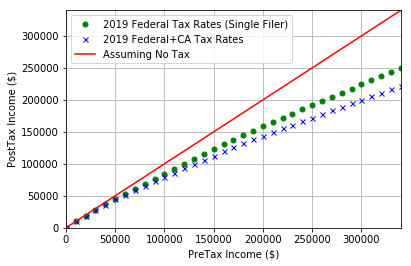

In [2]:
import matplotlib.pyplot as plt

pretax_income = np.arange(0, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax(pretax_income, state_tax=[]), 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, posttax(pretax_income, state_tax=ca_tax_rates), 'xb', ms=5, label='2019 Federal+CA Tax Rates')
plt.plot(pretax_income, pretax_income, '-r', ms=4, label='Assuming No Tax')
plt.axis([0,pretax_income[-1],0,pretax_income[-1]])
ax.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('PostTax Income ($)')
plt.grid()

plt.show()


Pretax Income ranging from 75000 to 345000
Avg approx error is 0.0038
Polynomial terms are [-4.94658938e-07  8.94934191e-01]


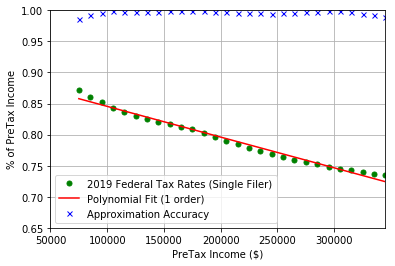

In [3]:
pretax_income = np.arange(75 * 1000, 350 * 1000, 10 * 1000)
posttax_income = posttax(pretax_income)
posttax_income_as_percent = posttax_income/pretax_income
polyfit_order = 1
approx_percent_polynom = np.poly1d(np.polyfit(pretax_income, posttax_income/pretax_income, polyfit_order))
approx_percent = approx_percent_polynom(pretax_income)
approximation_error = [abs(x-y) for x, y  in zip(approx_percent, posttax_income_as_percent)]
avg_approx_error = np.average(approximation_error)
approximation_accuracy = [1-x for x in approximation_error]

print('Pretax Income ranging from {} to {}'.format(pretax_income[0], pretax_income[-1]))
print('Avg approx error is {:.2}'.format(avg_approx_error))
print('Polynomial terms are {}'.format(np.asarray(approx_percent_polynom)))

fig, ax = plt.subplots()
plt.plot(pretax_income, posttax_income_as_percent, 'og', ms=5, label='2019 Federal Tax Rates (Single Filer)')
plt.plot(pretax_income, approx_percent, '-r', ms=5, label='Polynomial Fit ({} order)'.format(polyfit_order))
plt.plot(pretax_income, approximation_accuracy, 'xb', ms=5, label='Approximation Accuracy')
plt.axis([50000,pretax_income[-1],0.65,1])
ax.legend()
ax.set_xlabel('PreTax Income ($)')
ax.set_ylabel('% of PreTax Income')
plt.grid()
plt.show()


In [4]:
import sys
class RecurringCashflow:
    def define_monthly(self, monthly_flow, name, monthly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=False):
        self.define_yearly(monthly_flow * 12, name, monthly_nw*12, yearly_apr, year_start, year_end, taxable)
        return self
        
    def define_yearly(self, yearly_flow, name, yearly_nw=0, yearly_apr=1.0, year_start=0, year_end=sys.maxsize, taxable=False):
        self.yearly_flow = yearly_flow
        self.name = name
        self.yearly_nw = yearly_nw
        self.yearly_apr = yearly_apr
        self.year_start = year_start
        self.year_end = year_end
        self.taxable = taxable # Specified if this impacts your AGI - Salary and 401k, for example, are both 'taxable', 
                               # in that the 401k expense is negative taxable income
        return self            
    
    def cashflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
        
    def gross_income(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow > 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def taxable_amount(self, year):
        if year >= self.year_start and year <= self.year_end and self.taxable:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def expenses(self, year):
        if year >= self.year_start and year <= self.year_end and self.yearly_flow < 0:
            years_accumulated = year - self.year_start
            return self.yearly_flow * (self.yearly_apr**years_accumulated)
        else:
            return 0
    
    def nwflow(self, year):
        if year >= self.year_start and year <= self.year_end:
            years_accumulated = year - self.year_start
            return self.yearly_nw * (self.yearly_apr**years_accumulated)
        else:
            return 0
        
        
class CashflowModel():
    def __init__(self, name='Unnamed', state_tax=[]):
        self.cashflows = []
        self.name = name
        self.state_tax=state_tax
        
    def add_recurring_cashflow(self, recurring_cashflow):
        self.cashflows.append(recurring_cashflow)
        
    def add_monthly(self, *args, **kwargs):
        rc = RecurringCashflow().define_monthly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def add_yearly(self, *args, **kwargs):
        rc = RecurringCashflow().define_yearly(*args, **kwargs)
        self.add_recurring_cashflow(rc)
        
    def get_cashflow(self, year):
        return sum([x.cashflow(year) for x in self.cashflows])
    
    def get_gross_income(self, year):
        return sum([x.gross_income(year) for x in self.cashflows])
    
    def get_taxable_income(self, year):
        return max(0,sum([x.taxable_amount(year) for x in self.cashflows]))
    
    def get_expenses(self, year):
        return sum([x.expenses(year) for x in self.cashflows])
        
    def get_nwflow(self, year):
        return sum([x.nwflow(year) for x in self.cashflows])
    
    def plot_annual_flow(self, year=0):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)
        axs = plt.subplot(1,2,1)
        cashflow_list = [(x.expenses(year)) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Annual Expenses (${})'.format(self.get_expenses(year)))
        axs = plt.subplot(1,2,2)
        nwflow_list = [x.nwflow(year) for x in self.cashflows]
        #nwflow_labels = [x.name +' (${})'.format(int(x.nwflow(year))) if x.yearly_nw != 0 else '' for x in self.cashflows]
        nwflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows,nwflow_list)]
        plt.pie(nwflow_list, labels=nwflow_labels)
        plt.title('Yearly NW Flow (${})'.format(int(sum([x.nwflow(year) for x in self.cashflows]))))
        plt.suptitle('Annual Cashflows for $\it{}$'.format(self.name))
        plt.show()
        
    def plot_monthly_flow(self, year=0):
        fig, axs = plt.subplots(1,2,figsize=(14,6), constrained_layout=True)
        axs = plt.subplot(1,2,1)
        cashflow_list = [int(x.cashflow(year)/12) for x in self.cashflows]
        cashflow_labels = [x.name + '(${})'.format(int(y/12)) if y != 0 else '' for x,y in zip(self.cashflows, cashflow_list)]
        plt.pie(np.absolute(cashflow_list), labels=cashflow_labels)
        plt.title('Net Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        plt.title('Monthly Cashflows (${})'.format(int(self.get_cashflow(year)/12)))
        axs = plt.subplot(1,2,2)
        monthly_nwflow_list = [x.nwflow(year)/12 for x in self.cashflows]
        monthly_nwflow_labels = [x.name + '(${})'.format(int(y)) if y != 0 else '' for x,y in zip(self.cashflows,monthly_nwflow_list)]
        plt.pie(monthly_nwflow_list, labels=monthly_nwflow_labels)
        plt.title('Monthly NW Flow (${})'.format(int(sum(monthly_nwflow_list))))
        plt.suptitle('Monthly Cashflows for $\it{}$'.format(self.name))
        plt.show()




In [5]:
import pandas as pd
import copy
import time
import matplotlib.ticker

# We create a list of dictionaries, where each entry/dict is one row

class FinancialModel:
    # A Financial Model takes in initial conditions and a CashflowModel, creating a time history of key metrics:
    # Total Net Worth, Annual Outflows, Annual NW Increase, Annual Pretax Required, and Year ID
    # These are returned in a dataframe by 'sim', then passed to plotting/analysis/stored
    # In any given year, if income > expenses, the difference is added to net worth
    
    def __init__(self, year=0, max_nw=8*1000*1000):
        self.year=year
        self.max_nw = max_nw
    
    def sim_basic(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr=1.075494565):
        return self.sim(cashflowmodel, nyears=nyears, initial_nw=initial_nw, nw_apr_avg=nw_apr, nw_apr_stdev=0, nruns=1)

    # Default nw APR and stdev are taken from S&P actual returns, 1928->2019
    def sim(self, cashflowmodel, nyears=30, initial_nw=0, nw_apr_avg=1.075494565, nw_apr_stdev=0.189442643, nruns=100):
        sim_run_dfs = []
        df_summary = {}
        df_summary['name'] = ('{}+{} @ {}+/-{} for {} yrs'.format(cashflowmodel.name, initial_nw, round(nw_apr_avg,3), round(nw_apr_stdev,3), nyears))
        print('Starting sim for {} ...'.format(df_summary['name']), end=' ')
        start_time = time.monotonic()
        for run in np.arange(0,nruns): # should use >= 100 runs for some statistical interest
            this_year = {}
            this_year['NetWorthInterest'] = 0
            this_year['NetWorth'] = initial_nw
            this_year['GrossIncome'] = 0
            this_year['TaxableIncome'] = 0
            this_year['Expenses'] = 0
            this_year['IncomeTax'] = 0
            this_year['ExplicitNWGrowth'] = 0
            this_year['ExcessCash'] = 0
            this_year['nw_apr'] = 1.0
            this_year['Year ID'] = 0
            year = []
            year.insert(0,copy.deepcopy(this_year))
            last_year = year[0]
            #years.append(copy.deepcopy(last_year))
            for current_year_id in np.arange(1,nyears):
                # Each year, we increase our networth by some percentage due to asset appreciation
                # We do not (yet) modify or alter our outflows, annual nw increase, or pretax required
                nw_apr = np.random.normal(loc = nw_apr_avg, scale = nw_apr_stdev, size = 1)[0]
                this_year = {}
                this_year['NetWorthInterest'] = int(last_year.get('NetWorth',0) * (nw_apr-1.0))
                this_year['NetWorth'] = min(self.max_nw, int(last_year['NetWorth'] + this_year['NetWorthInterest'] + last_year.get('ExplicitNWGrowth',0) + last_year.get('ExcessCash',0)))
                this_year['GrossIncome'] = int(cashflowmodel.get_gross_income(current_year_id))
                this_year['TaxableIncome'] = int(cashflowmodel.get_taxable_income(current_year_id))
                this_year['Expenses'] = int(cashflowmodel.get_expenses(current_year_id))
                this_year['IncomeTax'] = int(incometax(this_year['TaxableIncome'], cashflowmodel.state_tax))
                this_year['ExplicitNWGrowth'] = int(cashflowmodel.get_nwflow(current_year_id))
                this_year['ExcessCash'] = int(this_year['GrossIncome'] + this_year['Expenses'] - this_year['IncomeTax'])
                this_year['nw_apr'] = nw_apr
                this_year['Year ID'] = current_year_id
                year.insert(current_year_id,copy.deepcopy(this_year))
                last_year = year[current_year_id]
            sim_run_dfs.append(pd.DataFrame(year))
        # We now have a list of DataFrames to process... 
        all_dfs = pd.concat(sim_run_dfs)
        year_summary = {}
        years = []
        for current_year_id in np.arange(1, nyears):
            this_years_rows = [df.loc[df['Year ID'] == current_year_id] for df in sim_run_dfs]
            this_years_rows = pd.concat(this_years_rows)
            dict_keys = ['NetWorthInterest', 'NetWorth', 'GrossIncome', 'TaxableIncome', 'Expenses', 'IncomeTax', 'ExplicitNWGrowth', 'ExcessCash', 'nw_apr', 'Year ID']
            for dk in dict_keys:
                year_summary[dk] = np.mean(this_years_rows[dk])
                year_summary[dk+':STDEV:top'] = np.mean(this_years_rows[dk]) + np.std(this_years_rows[dk])
                year_summary[dk+':STDEV:bottom'] = np.mean(this_years_rows[dk]) - np.std(this_years_rows[dk])
                year_summary[dk+':0.80:top'] = np.percentile(this_years_rows[dk],90)
                year_summary[dk+':0.80:bottom'] = np.percentile(this_years_rows[dk],10)
            this_year = copy.deepcopy(year_summary)
            years.append(this_year)
        df_summary['nyears'] = nyears
        df_summary['initial_nw'] = initial_nw
        df_summary['nw_apr'] = nw_apr_avg
        df_summary['nw_apr_stdev'] = nw_apr_stdev
        print('Finished in {} seconds'.format(round(time.monotonic()-start_time,1)))
        return (pd.DataFrame(years), df_summary)
    
    def plot(self, df_tuple, suffix=':STDEV', autoscale_y=True, max_thousands=5*1000, year_start=1, year_end=20):
        fig, axs = plt.subplots(2,3,figsize=(17,9), constrained_layout=False)
        if isinstance(df_tuple, list):
            df_tuple_list = df_tuple
        else:
            df_tuple_list = [df_tuple]
        fields_to_plot = ['NetWorth', 'NetWorthInterest', 'ExplicitNWGrowth', 'TaxableIncome', 'Expenses', 'ExcessCash']
        cur_ax_id = 0
        for field in fields_to_plot:
            ax = axs.flat[cur_ax_id]
            cur_ax_id = cur_ax_id + 1
            max_y = np.max([np.max(df[field]/1000) for df, df_summary in df_tuple_list])
            min_y = np.min([np.min(df[field]/1000) for df, df_summary in df_tuple_list])
            for df, df_summary in df_tuple_list:
                top_bottom_differences = [t-b for t,b in zip(df[field+suffix+':top'],df[field+suffix+':bottom'])]
                should_plot_error_bars = True if np.max(top_bottom_differences) > 1000 else False
                #print('For {} in {}, speb is {} due to {}'.format(field+suffix, df_summary['name'], should_plot_error_bars,np.max(top_bottom_differences)))
                if should_plot_error_bars:
                    thisplot = ax.plot(df['Year ID']+self.year, df[field]/1000, '-', label='{}'.format(df_summary['name']))
                    thisplot_color = thisplot[0].get_color()
                    top_bar = [t/1000 for t in df[field+suffix+':top']]
                    bottom_bar = [b/1000 for b in df[field+suffix+':bottom']]
                    ax.fill_between(df['Year ID']+self.year, bottom_bar, top_bar, color=thisplot_color, alpha=0.2)
                else:
                    ax.plot(df['Year ID']+self.year, df[field]/1000, label='{}'.format(df_summary['name']))
                handles, labels = ax.get_legend_handles_labels()
            ax.set_xlim(left=self.year+year_start, right=self.year+year_end)
            ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
            y_range = max_y - min_y
            if autoscale_y:
                ax.set_ylim(bottom=min_y-0.05*y_range, top=min(max_y+0.05*y_range, max_thousands))
            if self.year is 0:
                ax.set_xlabel('Years Since Initial Conditions')
            else:
                ax.set_xlabel('Year')
            ax.set_ylabel('{} (Thousands of $)'.format(field))
            ax.grid()
        fig.subplots_adjust(top=0.9) # Prevents constrained_layout 
        fig.legend(handles, labels, loc='upper center')
        plt.show()

fm = FinancialModel(year=2019)

sim_results = [] # We'll append all sim results to this list for one large fm plot at the end
ho_single = CashflowModel('Home Ownership (Single/NonCA)') #Home Ownership Model (as compared to renting, etc)
cm = ho_single
cm.add_yearly(200000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-4000, 'Pri. Res.', monthly_nw=2000, year_end=15)
cm.add_monthly(-2000, 'Sec. Res.', monthly_nw=1000, year_start=4, year_end=19)
cm.add_monthly(-800, 'Auto Costs', yearly_apr=1.01) # Two vehicles - car and truck, one as a 'beater'
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=25, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=25)
cm.add_monthly(-3000, 'Monthly Spend')
cm.add_yearly(-12000, 'Yearly Spend')

ho_dual = CashflowModel('Home Ownership (Dual/NonCA)') #Home Ownership Model (as compared to renting, etc)
cm = ho_dual
cm.add_yearly(200000, 'Salary (A)', year_end=20, taxable=True)
cm.add_yearly(90000, 'Salary (B)', year_start=4, year_end=30, taxable=True)
cm.add_monthly(-4000, 'Pri. Res.', monthly_nw=2150, year_end=15)
cm.add_monthly(-2000, 'Sec. Res.', monthly_nw=1100, year_start=5, year_end=20)
cm.add_monthly(-2000, 'School Loans', year_start=4, year_end=19)
cm.add_monthly(-1000, 'Auto Costs', yearly_apr=1.01) # Mild upgrade to the two vehicles, as both are commuters now
cm.add_yearly(-19000, '401k Savings (A)', yearly_nw=19000, year_end=25, taxable=True)
cm.add_yearly(-10000, '401k Savings (B)', yearly_nw=10000, year_start=4, year_end=35, taxable=True)
cm.add_yearly(-5000, 'IRA Savings (A)', yearly_nw=5000,year_end=25)
cm.add_yearly(-3000, 'IRA Savings (B)', yearly_nw=3000, year_start=4, year_end=35)
cm.add_monthly(-4500, 'Monthly Spend')
cm.add_yearly(-18000, 'Yearly Spend')

renting_single = CashflowModel('Renting Model (Single/CA)', state_tax=ca_tax_rates)
cm = renting_single
cm.add_yearly(330000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-4500, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-500, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3500, 'Monthly Spend') # CA is expensive
cm.add_yearly(-15000, 'Yearly Spend') # CA is expensive


sims_to_run = [ho_single, ho_dual, renting_single]
sim_results = []

for sim in sims_to_run:
    sim_results.append(fm.sim(sim, nyears=25, initial_nw=600000, nw_apr_avg=1.07, nw_apr_stdev=0.05))
# The default suffix is just standard deviation. The :0.80 suffix gives me the 10th and 90th percentile bars on plots
fm.plot(sim_results, suffix=':0.80')

sims_to_run = [ho_single, ho_dual, renting_single]
sim_results = []
# These sims use the default args based on real stock market data over time
for sim in sims_to_run:
    sim_results.append(fm.sim(sim, nyears=35, initial_nw=650000))
fm.plot(sim_results, suffix=':0.80', year_end=8, max_thousands=4*1000)




In [6]:
basic_single = CashflowModel('Basic Model (Single/CA)', state_tax=ca_tax_rates)
cm = basic_single
cm.add_yearly(210000, 'Salary', year_end=20, taxable=True)
cm.add_monthly(-3500, 'Primary Residence', monthly_nw=0)
cm.add_monthly(-500, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3500, 'Monthly Spend') # CA is expensive
cm.add_yearly(-12000, 'Yearly Spend')

complex_single = CashflowModel('Complex Model (Single/CA)', state_tax=ca_tax_rates)
cm = complex_single
cm.add_yearly(375000, 'Salary', year_end=4, taxable=True)
cm.add_monthly(-4200, 'Renting', year_end=4)
cm.add_yearly(190000, 'Salary', year_start=5, year_end=20, taxable=True)
cm.add_monthly(-4200, 'Buying', year_start=5, year_end=20, monthly_nw=2100)
cm.add_monthly(-2200, 'Buying 2nd', year_start=8, year_end=23, monthly_nw=1000)
cm.add_monthly(-500, 'Auto Costs', yearly_apr=1.01)
cm.add_yearly(-19000, '401k Savings', yearly_nw=19000, year_end=20, taxable=True)
cm.add_yearly(-5000, 'IRA Savings', yearly_nw=5000, year_end=20)
cm.add_monthly(-3250, 'Monthly Spend', yearly_apr=1.01)
cm.add_yearly(-12000, 'Yearly Spend', yearly_apr=1.01)

sims_to_run = [basic_single, complex_single]
sim_results = []
# These sims use the default args based on real stock market data over time
for sim in sims_to_run:
    sim_results.append(fm.sim(sim, nyears=45, initial_nw=650000))
fm.plot(sim_results, suffix=':0.80')


NameError: name 'fm' is not defined

In [13]:
import scipy.optimize
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker
import time

def pay_monthly_on_loan(initial_value, apr, duration_years, monthly_payment):
    principal = {0:initial_value}
    for year in np.arange(1,duration_years):
        principal[year] = principal[year-1] * apr - 12 * monthly_payment
    return principal[year]

def find_monthly_payment(loan_value, apr, duration_years):
    principal_remaining = lambda monthly_payment : pay_monthly_on_loan(loan_value, apr, duration_years, monthly_payment)
    # Use a Brent gradient approach method of solving roots to determine the proper value
    payment_needed = scipy.optimize.brentq(principal_remaining, 0, loan_value * (apr**duration_years))
    return round(payment_needed)


def pay_yearly_on_loan(initial_value, apr, duration_years, yearly_payment):
    principal = {0:initial_value}
    for year in np.arange(1,duration_years):
        principal[year] = principal[year-1] * apr - yearly_payment
    return principal[year]

def find_yearly_payment(loan_value, apr, duration_years):
    principal_remaining = lambda yearly_payment : pay_yearly_on_loan(loan_value, apr, duration_years, yearly_payment)
    # Use a Brent gradient approach method of solving roots to determine the proper value
    payment_needed = scipy.optimize.brentq(principal_remaining, 0, loan_value * (apr**duration_years))
    return round(payment_needed)

loan_value = 400 * 1000
apr = 1.05
monthly_30 = find_monthly_payment(loan_value, apr, 30)
monthly_15 = find_monthly_payment(loan_value, apr, 15)
paid_30 = monthly_30 * 12 * 30
paid_15 = monthly_15 * 12 * 15
print(f'For {loan_value}@{apr}, the 30-year payment is {monthly_30} while it\'s {monthly_15} for 15, totalling {paid_30} and {paid_15} respectively')

# Things like homes require upkeep, maintenance, property taxes, and insurance.
# I estimate those as 2% of the home value per year

# If we want to model net worth, we _might_ be able to do it as a curve-fit of sorts

class Parameters:
    def __init__(self):
        self.max_years=50
        self.default_apr=1.06
        self.min_apr=0.75
        self.max_apr=1.25

class FinancialEvent(object):    
    def __init__(self):
        self.name = 'Unnamed'
        self.definedas = 'NeverDefined'
        self.cashflow = {}
        self.agi_impacting = False
        
    def define_single(self, amount, name, year, agi_impacting=None):
        self.name = name
        self.definedas = 'single'
        self.cashflow[year] = amount
        if agi_impacting is None:
            # We presume all income is taxed, and expenses don't reduce taxable income unless explicitly specified
            agi_impacting = True if yearly_amount >= 0 else False
        else:
            self.agi_impacting = agi_impacting
        return self
        
    def define_yearly(self, yearly_amount, name, year_start=0, year_end=Parameters().max_years, agi_impacting=None, apr=1.0, definedas='yearly'):
        self.name = name
        self.definedas = definedas
        if agi_impacting is None:
            # We presume all income is taxed, and expenses don't reduce taxable income unless explicitly specified
            agi_impacting = True if yearly_amount >= 0 else False
        else:
            self.agi_impacting = agi_impacting
        if year_start > year_end or year_end > Parameters().max_years:
            raise ValueError
        for year in np.arange(year_start, year_end):
            self.cashflow[year] = yearly_amount * (apr ** (year-year_start))
        return self
    
    def define_monthly(self, monthly_amount, name, year_start=0, year_end=Parameters().max_years, agi_impacting=None, apr=1.0):
        self.define_yearly(yearly_amount = monthly_amount * 12, name=name, year_start=year_start, year_end=year_end, agi_impacting=agi_impacting, apr=apr, definedas='monthly')
        return self
        
    def define_loan(self, loan_value, name, duration, year_start=0, agi_impacting=None, apr=Parameters().default_apr, early_payoff_year=Parameters().max_years):
        self.name = name
        self.definedas = 'loan'
        self.agi_impacting = False if agi_impacting is None else agi_impacting
        if year_start+duration > Parameters().max_years or duration < 0 or Parameters().min_apr > apr > Parameters().max_apr:
            raise ValueError
        yearly_payment = find_yearly_payment(loan_value, apr, duration)
        payoff_year = min(year_start+duration, early_payoff_year)
        for year in np.arange(year_start, payoff_year):
            self.cashflow[year] = int(-yearly_payment)
        principal_remaining = int(pay_yearly_on_loan(loan_value, apr, year-year_start, yearly_payment))
        # I believe there's a fencepost error here - early testing showed that the final year had payments of _nearly_ 2X a normal
        # year to close the account without an 'extra' year
        self.cashflow[year] = int(-yearly_payment - principal_remaining)
        return self
    
    def gross_income(self, year):
        return self.cashflow.get(year, 0)
        
    def adjusted_gross_income(self, year):
        return self.gross_income(year) if self.agi_impacting else 0
    
    def scatterdata(self, year_start=0, year_end=None):
        xvalues = [k for k in self.cashflow]
        yvalues = [self.gross_income(year) for year in xvalues]
        average = np.average(yvalues)
        return xvalues, yvalues, self.name + f' ({int(average)} avg)'


class FinancialModel:
    def __init__(self, name='Unnamed', real_year=0, nw_apr=1.06, nw_apr_stdev=0.08):
        self.name = name
        self.real_year = real_year
        self.nw_apr = nw_apr
        self.nw_apr_stdev = nw_apr_stdev
        self.fevents = []
        
    def add_single(self, *args, **kwargs):
        fe = FinancialEvent().define_single(*args, **kwargs)
        self.fevents.append(fe)
    
    def add_monthly(self, *args, **kwargs):
        fe = FinancialEvent().define_monthly(*args, **kwargs)
        self.fevents.append(fe)
        
    def add_yearly(self, *args, **kwargs):
        fe = FinancialEvent().define_yearly(*args, **kwargs)
        self.fevents.append(fe)
    
    def add_loan(self, *args, **kwargs):
        fe = FinancialEvent().define_loan(*args, **kwargs)
        self.fevents.append(fe)
        
    def add_fevent(self, fevent):
        self.fevents.append(fevent)
        
    def add_fevents(self, fevents):
        self.fevents.extend(fevents)
            
    def plot_cashflow(self, year_start=0, year_end=25):
        fig, axs = plt.subplots(1,2,figsize=(12,5), constrained_layout=True, sharex=True)
        ax = axs.flat[0]
        years=np.arange(year_start, year_end)
        max_y = np.max([np.max([fe.gross_income(year) for year in years]) for fe in self.fevents])
        min_y = np.min([np.min([fe.gross_income(year) for year in years]) for fe in self.fevents])
        ax.set_xlim(left=self.real_year+year_start, right=self.real_year+year_end)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        for fe in self.fevents:
            xvalues, yvalues, label = fe.scatterdata(year_start, year_end)
            xvalues = list(map(lambda x: x + self.real_year, xvalues))
            yvalues = list(map(lambda y: y, yvalues))
            ax.scatter(xvalues, yvalues, label=label)
            ax.plot(xvalues,yvalues)
            handles, labels = ax.get_legend_handles_labels()
        y_range = max_y - min_y
        ax.set_ylim(bottom=min_y-0.05*y_range, top=max_y+0.05*y_range)
        if self.real_year is 0:
            ax.set_xlabel('Years Since Initial Conditions')
        else:
            ax.set_xlabel('Year')
        ax.set_ylabel('Dollars')
        ax.grid()
        ax.legend(handles, labels)
        ax = axs.flat[1]
        # Second plot shows: Total Income per year, AGI per year, Total Expenses per year
        combined_gross_income = [0 for _ in years]
        combined_agi = [0 for _ in years]
        posttax = [0 for _ in years]
        combined_expenses = [0 for _ in years]
        for fe in self.fevents:
            for year in years:
                combined_gross_income[year] = combined_gross_income[year] + fe.gross_income(year) if fe.gross_income(year) > 0 else combined_gross_income[year]
                combined_agi[year] = combined_agi[year] + fe.adjusted_gross_income(year) if fe.adjusted_gross_income(year) > 0 else combined_agi[year]
                posttax[year] = combined_gross_income[year] - incometax(combined_agi[year])
                combined_expenses[year] = combined_expenses[year] - fe.gross_income(year) if fe.gross_income(year) < 0 else combined_expenses[year]
        real_years = list(map(lambda x: x + self.real_year, years)) 
        ax.scatter(real_years, combined_gross_income, label='Total Gross Income')
        ax.plot(real_years, combined_gross_income)
        ax.scatter(real_years, combined_agi, label='Total Adjusted Gross Income')
        ax.plot(real_years, combined_agi)
        ax.scatter(real_years, posttax, label='PostTax Income')
        ax.plot(real_years, posttax)
        # ax.scatter(real_years, combined_expenses, label='Total Expenses')
        # ax.plot(real_years, combined_expenses)
        ax.scatter(real_years, [agi-exp for agi,exp in zip(combined_agi, combined_expenses)], label='PostTax Minus Expenses')
        ax.plot(real_years, [agi-exp for agi,exp in zip(combined_agi, combined_expenses)])
        ax.set_xlim(left=np.min(real_years), right=np.max(real_years))
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        if self.real_year is 0:
            ax.set_xlabel('Years Since Initial Conditions')
        else:
            ax.set_xlabel('Year')
        ax.set_ylabel('Dollars')
        ax.grid()
        ax.legend()
        plt.show()

    @staticmethod
    def get_simyearhash(simkey, year):
        if simkey is None:
            return f'Year#{str(year)}'
        else:
            if '#' in str(simkey) or ':' in str(simkey):
                raise ValueError('Cannot have # or : in simkeys. Try numbers instead')
            return f'Sim:{str(simkey)}:Year#{str(year)}'
    
            # Default nw APR and stdev are taken from S&P actual returns, 1928->2019
    def simonce(self, nyears=30, initial_nw=0, nw_apr_avg=1.075494565, nw_apr_stdev=0.189442643, simkey=None):
        sim_summary = {}
        sim_summary['name'] = ('{}+{} @ {}+/-{} for {} yrs'.format(self.name, initial_nw, round(nw_apr_avg,3), round(nw_apr_stdev,3), nyears))
        sim_summary['simkey'] = simkey
        results = {}
        results[self.get_simyearhash(simkey, 0)] = {'Net Worth':initial_nw}
        for cur_year in np.arange(1, nyears):
            try:
                this_year = results[self.get_simyearhash(simkey, cur_year)] = {}
                last_year = results[self.get_simyearhash(simkey, cur_year - 1)]
            except Exception as e:
                print(f'simkey:{simkey} and cur_year:{cur_year}')
                raise e
            nw_apr = max(0,np.random.normal(loc = nw_apr_avg, scale = nw_apr_stdev, size = 1)[0])
            net_worth_interest = last_year.get('Net Worth', 0) * (nw_apr - 1.0)
            this_year['Net Worth'] = last_year['Net Worth'] + net_worth_interest + last_year.get('Net Gain',0)
            this_year['Gross Income'] = np.sum([max(0, fe.gross_income(cur_year)) for fe in self.fevents])
            this_year['Adjusted Gross Income'] = np.sum([max(0,fe.adjusted_gross_income(cur_year)) for fe in self.fevents])
            this_year['Taxes'] = incometax(this_year['Adjusted Gross Income'])
            posttax_income = this_year['Gross Income'] - this_year['Taxes']
            this_year['Expenses'] = abs(np.sum([min(0,fe.gross_income(cur_year)) for fe in self.fevents]))
            this_year['Net Gain'] = posttax_income - this_year['Expenses']
        return results, sim_summary
    
    def simmany(self, nruns=100, nyears=30, **kwargs):
        print(f'Starting to simulate {nruns} runs for {nyears} each...]', end='')
        start_time = time.monotonic()
        master_results = {}
        simkeys = [simnum for simnum in np.arange(1,nruns)]
        simresults = [self.simonce(simkey=simkey, **kwargs) for simkey in simkeys]
        print('Finished simulating in {} seconds...'.format(round(time.monotonic()-start_time,1)), end=' ')
        start_time = time.monotonic()
        for results, sim_summary in simresults:
            master_results.update(results)
        medianop = lambda values: np.median(values)
        meanop = lambda values: np.median(values)
        stdevop = lambda values: np.std(values)
        tenpercentop = lambda values: np.percentile(values, 10)
        ninetypercentop = lambda values: np.percentile(values, 90)
        Summaries = {'Median': medianop, 'Mean': meanop, 'STDEV': stdevop, '10%':tenpercentop, '90%':ninetypercentop}
        resultkeys = ['Net Worth', 'Gross Income', 'Adjusted Gross Income', 'Taxes', 'Expenses', 'Net Gain']
        master_summary = {'nruns':nruns, 'nyears':nyears, 'simkeys':simkeys, 'Summaries':Summaries, 'resultkeys':resultkeys}
        for summary in Summaries:
                for year in np.arange(1, nyears):
                    master_results[self.get_simyearhash(summary, year)] = {}
                    for result in resultkeys:
                        result_list = [master_results[self.get_simyearhash(simkey,year)][result] for simkey in simkeys]
                        master_results[self.get_simyearhash(summary, year)][result] = Summaries[summary](result_list)
        print('Finished summarizing in {} seconds'.format(round(time.monotonic()-start_time,1)))
        return master_results, master_summary

    def get_plotdata(self, master_tuple, summary='Mean', result='Net Worth'):
        master_results, master_summary = master_tuple
        xvalues = np.arange(1,master_summary['nyears']) 
        yvalues = [master_results[self.get_simyearhash(summary,year)] for year in xvalues]
        label = f'{summary} {result}'
        return xvalues, yvalues, label
    
    def plot(self, master_tuple):
        fig, ax = plt.subplots()
        master_results, master_summary = master_tuple
        # For now, we only want to plot the Mean of Net worth, and make it pretty later
        summary='Mean'
        results=['Net Worth', 'Gross Income', 'Expenses', 'Net Gain']
        xvalues = [x for x in np.arange(1,master_summary['nyears'])] 
        real_years = [x+self.real_year for x in xvalues]
        for result in results:
            yvalues = [master_results[self.get_simyearhash(summary,year)][result] for year in xvalues]
            label = f'{summary} {result}'
            ax.plot(real_years, yvalues, label=label)
            
        ax.legend()
        ax.set_xlim(left=np.min(real_years), right=np.max(real_years))
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        if self.real_year is 0:
            ax.set_xlabel('Years Since Initial Conditions')
        else:
            ax.set_xlabel('Year')
        
        ax.set_ylabel('Current Value Dollars')
        plt.grid()
        plt.show()


For 400000@1.05, the 30-year payment is 2202 while it's 3367 for 15, totalling 792720 and 606060 respectively


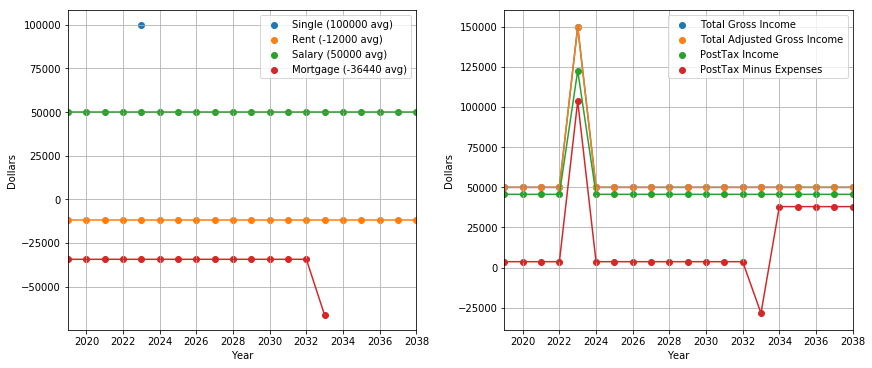

Starting to simulate 3 runs for 20 each...]Finished simulating in 0.0 seconds... Finished summarizing in 0.1 seconds


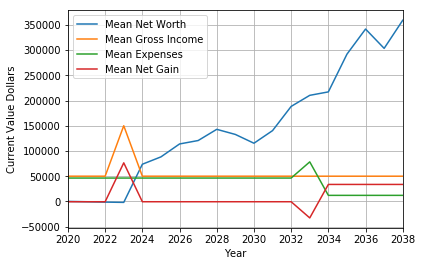

In [15]:
fm = FinancialModel('Test Model', 2019)
fm.add_single(100 * 1000, 'Single', 4, agi_impacting=True)
fm.add_monthly(-1000, 'Rent')
fm.add_yearly(50 * 1000, 'Salary', agi_impacting=True)
fm.add_loan(300 * 1000, 'Mortgage', 15, apr=1.07)
fm.plot_cashflow(year_end=20)

result_tuple = fm.simonce()
master_tuple = fm.simmany(nruns=3, nyears=20)
fm.plot(master_tuple)

# Eventual goal is to put those four results (NW, GI, Expenses, Savings) on a 2x2 grid, stacking several sims at once on it
# Can also imagine that when each sim is defined, doing a plot_cashflow on it in a list, to show what's going on in it
